In [1]:
!pip install git+https://github.com/macrosynergy/macrosynergy@develop

  Cloning https://github.com/macrosynergy/macrosynergy (to revision develop) to /tmp/pip-req-build-91gusf9g
  Running command git clone --filter=blob:none --quiet https://github.com/macrosynergy/macrosynergy /tmp/pip-req-build-91gusf9g
  Resolved https://github.com/macrosynergy/macrosynergy to commit 2f284af8abe8d19af078f870b80a33eefaaa9160
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for macrosynergy: filename=macrosynergy-0.0.51.dev0+20231208054036.2f284af-py3-none-any.whl size=217429 sha256=266440c27744ca9bd61cb4e75a375445d578c562065703b562928f7c2e2100b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_pjovzl/wheels/42/8e/1b/3720977af11deed4a4fc44597ff1223046d9e28a47c91bb946
Successfully built macrosynergy
  Attempting uninstall: macrosynergy
    Found existing installation: macrosynergy 0.0.51.dev0+20231208030821.2f284af
    Uninstalling macrosynergy-0.0.51.dev0+202312080308

In [2]:
!pip install pmdarima

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn


import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


from sklearn.model_selection import TimeSeriesSplit
from keras.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score


In [4]:
# Cross-sections of interest

cids_dm = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK", "USD"]
cids_em = [
    "CLP",
    "COP",
    "CZK",
    "HUF",
    "IDR",
    "ILS",
    "INR",
    "KRW",
    "MXN",
    "PLN",
    "THB",
    "TRY",
    "TWD",
    "ZAR",
]
cids = cids_dm + cids_em
cids_du = cids_dm + cids_em
cids_dux = list(set(cids_du) - set(["IDR", "NZD"]))
cids_xg2 = list(set(cids_dux) - set(["EUR", "USD"]))

In [5]:
# Quantamental categories of interest

ecos = [
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "PCREDITGDP_SJA_D1M1ML12",
    "PCREDITBN_SJA_P1M1ML12",
    "RGDP_SA_P1Q1QL4_20QMA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
]
mkts = [
    "DU02YXR_NSA",
    "DU05YXR_NSA",
    "DU02YXR_VT10",
    "DU05YXR_VT10",
    "EQXR_NSA",
    "EQXR_VT10",
    "FXXR_NSA",
    "FXXR_VT10",
    "FXCRR_NSA",
    "FXTARGETED_NSA",
    "FXUNTRADABLE_NSA",
]

xcats = ecos + mkts

In [6]:
# load the dataset:

df = pd.read_csv('JPMaQS_Quantamental_Indicators.csv', index_col=0, parse_dates=['real_date'])

scols = ["cid", "xcat", "real_date", "value"]  # required columns
df = df[scols].copy()
display (df.tail(3))
df.info()

,cid,xcat,real_date,value
3350268,ZAR,RGDP_SA_P1Q1QL4_20QMA,2023-08-31,0.534737
3350269,ZAR,RYLDIRS02Y_NSA,2023-08-31,3.230619
3350270,ZAR,RYLDIRS05Y_NSA,2023-08-31,3.543863


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3350271 entries, 0 to 3350270
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   cid        object        
 1   xcat       object        
 2   real_date  datetime64[ns]
 3   value      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 127.8+ MB


In [7]:
display(df['xcat'].unique())
display(df['cid'].unique())
df['ticker'] = df['cid'] + "_" + df["xcat"]
df.set_index('real_date', inplace=True)
df.sort_index(inplace=True)

array(['CPIC_SA_P1M1ML12', 'CPIC_SJA_P3M3ML3AR', 'CPIC_SJA_P6M6ML6AR',
       'CPIH_SA_P1M1ML12', 'CPIH_SJA_P3M3ML3AR', 'CPIH_SJA_P6M6ML6AR',
       'FXTARGETED_NSA', 'FXUNTRADABLE_NSA', 'FXXR_NSA', 'FXXR_VT10',
       'INFTEFF_NSA', 'INTRGDP_NSA_P1M1ML12_3MMA',
       'INTRGDPv5Y_NSA_P1M1ML12_3MMA', 'PCREDITBN_SJA_P1M1ML12',
       'PCREDITGDP_SJA_D1M1ML12', 'RGDP_SA_P1Q1QL4_20QMA',
       'RYLDIRS02Y_NSA', 'RYLDIRS05Y_NSA', 'DU02YXR_NSA', 'DU02YXR_VT10',
       'DU05YXR_NSA', 'DU05YXR_VT10', 'EQXR_NSA', 'EQXR_VT10',
       'FXCRR_NSA'], dtype=object)

array(['AUD', 'CAD', 'CHF', 'CLP', 'COP', 'CZK', 'EUR', 'GBP', 'HUF',
       'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MXN', 'NOK', 'NZD', 'PLN',
       'SEK', 'THB', 'TRY', 'TWD', 'USD', 'ZAR'], dtype=object)

#ARIMA

In [8]:
df_USD = df[df["cid"] == 'USD']

# make the xcat features into columns
df_USD = df_USD.pivot_table(index='real_date', columns='xcat', values='value', aggfunc='first')

df_USD = df_USD.reset_index()

# deals with missing data
df_USD = df_USD.dropna()


# split into training and test data
tss = TimeSeriesSplit(n_splits = 4)


## Using timeseries split



In [9]:
for train_index, test_index in tss.split(df_USD):

    development_set = df_USD.iloc[train_index]
    test_set = df_USD.iloc[test_index]

    dev_y = development_set['DU05YXR_VT10']
    test_y = test_set['DU05YXR_VT10']

    model_autoARIMA = auto_arima(dev_y, start_p=0, start_q=0,
                      test='adf',       # use adftest to find  optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
    print(model_autoARIMA.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2633.535, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2626.909, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2625.982, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2626.536, Time=0.53 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2625.761, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2627.581, Time=0.73 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2627.355, Time=0.42 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2629.294, Time=1.62 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2623.214, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2623.873, Time=0.71 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2624.931, Time=3.86 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2624.637, Time=1.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2624.241, Time=1.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2626.590, Time=3.11 sec

Best model:  ARIMA(0,0,2)(0,0,0)

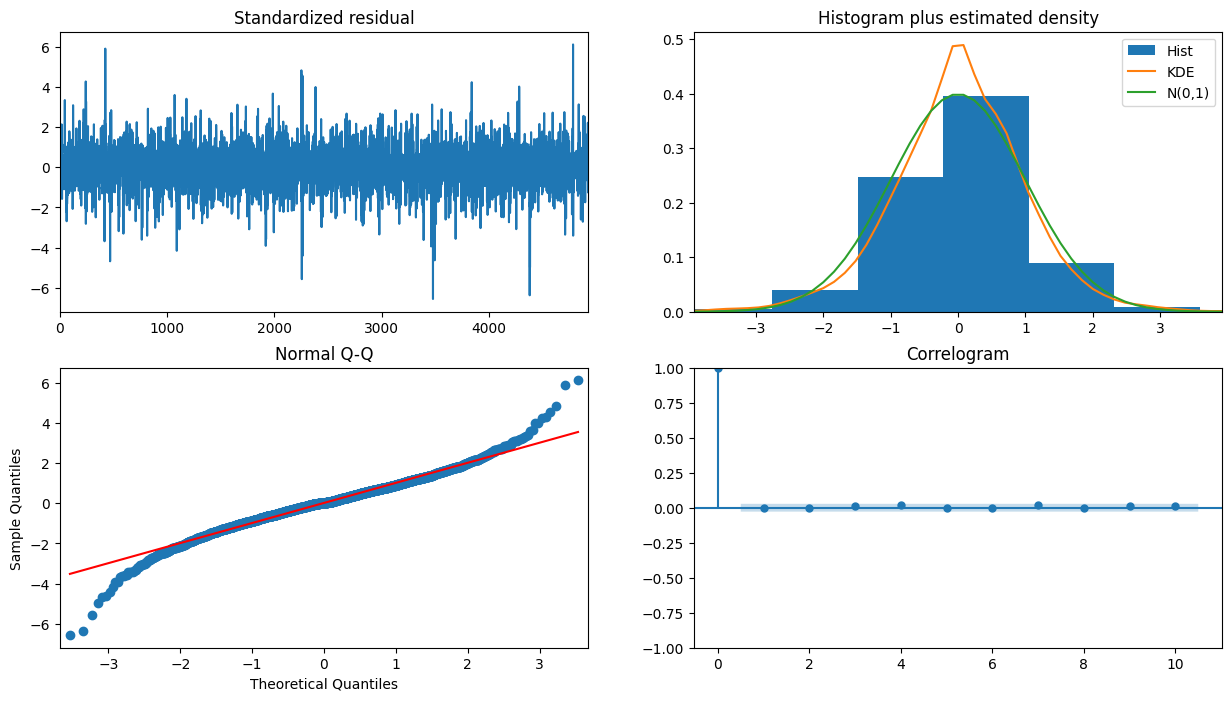

In [10]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [11]:
model1 = sm.tsa.arima.ARIMA(dev_y, order=(0, 0, 2))
model2 = sm.tsa.arima.ARIMA(dev_y, order=(2, 0, 0))

In [12]:
fitted1 = model1.fit()
print(fitted1.summary())
fitted2 = model1.fit()
print(fitted2.summary())

                               SARIMAX Results                                
Dep. Variable:           DU05YXR_VT10   No. Observations:                 4924
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -5167.518
Date:                Fri, 08 Dec 2023   AIC                          10343.036
Time:                        05:42:16   BIC                          10369.044
Sample:                             0   HQIC                         10352.158
                               - 4924                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0112      0.010      1.149      0.251      -0.008       0.030
ma.L1          0.0200      0.012      1.665      0.096      -0.004       0.044
ma.L2         -0.0360      0.013     -2.734      0.0

In [13]:
# Forecast
fc= fitted1.forecast(3000,alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_y.index)

In [16]:
print("Result for model 1: ")
print("MSE: ", mean_squared_error(test_y, fc_series))
print("RMSE: ", np.sqrt(mean_squared_error(test_y, fc_series)))
print("R2: ", r2_score(test_y, fc_series))

Result for model 1: 
MSE:  0.5579876224228788
RMSE:  0.7469856909090554
R2:  -0.0006006986336510867


In [17]:
# Forecast
fc= fitted2.forecast(3000,alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_y.index)
print("Result for model 2: ")
print("MSE: ", mean_squared_error(test_y, fc_series))
print("RMSE: ", np.sqrt(mean_squared_error(test_y, fc_series)))
print("R2: ", r2_score(test_y, fc_series))

Result for model 2: 
MSE:  0.5579876224228788
RMSE:  0.7469856909090554
R2:  -0.0006006986336510867
